# Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import zipfile
import os
from google.colab import files

# Preprocessing

## Uploading Files (run once)

In [2]:
uploaded = files.upload()

Saving archive.zip to archive.zip


In [3]:
zip_path = 'archive.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('data')

print(os.listdir('data'))

['Stocks', 'ETFs', 'Data']


In [4]:
curr = os.getcwd()
for filename in os.listdir(curr):
  if os.path.isfile(filename):
    os.remove(os.path.join(curr, filename))

## Making Data frames from the txt files

In [42]:
from pandas.errors import EmptyDataError
import random
def preprocessing(companies, min_days=60):
  data = pd.DataFrame()
  file_names = sorted(os.listdir('data/Stocks'))
  random.shuffle(file_names)
  selected_files = file_names[:(companies * 2)]
  nonEmptyCount = 1
  for i, filename in enumerate(file_names):
    if nonEmptyCount > companies:
      break
    if filename.endswith('.txt'):
      file_path = os.path.join('data/Data/Stocks', filename)
      if os.path.isfile(file_path):
        try:
          df = pd.read_csv(file_path, skip_blank_lines=True)
          if df.isnull().values.any():
                  print(f"Skipping file with missing values: {filename}")
                  continue  # Skip files with None or NaN values

          if len(df) < min_days:
                      print(f"Skipping file with less than {min_days} days of data: {filename}")
                      continue
          filename = filename.replace('.txt', '')
          df['Ticker'] = filename
          data = pd.concat([data, df], ignore_index=True)
          nonEmptyCount += 1
        except EmptyDataError:
          print(f'Skipping empty file: {filename}')

  total_tickers = data['Ticker'].nunique()
  print(total_tickers)
  return data

### Converting to sequences

In [85]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [86]:
def prepare_data(ticker_data, sequence_length, predicted_days=1):
  ticker_data_scaled = scaler.fit_transform(ticker_data[['Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']])
  X, y = [], []
  for i in range(sequence_length, len(ticker_data_scaled) - predicted_days + 1):
          X.append(ticker_data_scaled[i-sequence_length:i])  # Sequence
          y.append(ticker_data_scaled[i:i+predicted_days, 3])  # Close price
  X, y = np.array(X), np.array(y)
  return X, y

In [87]:
data = preprocessing(50)
tickers = data['Ticker'].unique()
all_X, all_y = [], []
sequence_length = 60  # 60 days or 2 month prediction. Change for longer term data
predicted_days = 7
for ticker in tickers:
    ticker_data = data[data['Ticker'] == ticker].sort_values(by='Date')
    X, y = prepare_data(ticker_data, sequence_length, predicted_days)
    all_X.append(X)
    all_y.append(y)



Skipping file with less than 60 days of data: fmdg.us.txt
Skipping file with less than 60 days of data: bcacw.us.txt
Skipping empty file: fmax.us.txt
Skipping file with less than 60 days of data: taxr.us.txt
Skipping file with less than 60 days of data: bio-b.us.txt
50


### 20 randomly selected company data (date vs closing price)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,25))



for i, ticker in enumerate(tickers[:20]):
  row = i //4
  col = i % 4
  ticker_data = data[data['Ticker'] == ticker]
  plt.subplot(5, 4, i+1)
  sns.lineplot(data=ticker_data, x='Date', y='Close')
  plt.title(f'{ticker} - Close')
  plt.xticks(rotation=45)
  plt.xlabel('Date')
  plt.ylabel('Close')


plt.tight_layout()
plt.show()

### Train-Test Split

In [92]:
X = np.concatenate(all_X, axis=0)
y = np.concatenate(all_y, axis=0)
y = np.array(y).reshape(-1, 7)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

(105635, 7)


# LSTM Model

In [94]:
# predicts the close price on the n+1 th day
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(predicted_days))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [95]:
model.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_test, y_test), verbose=1)
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

Epoch 1/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 83s 119ms/step - loss: 0.0159 - val_loss: 9.1791e-04
Epoch 2/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 76s 110ms/step - loss: 0.0021 - val_loss: 6.4687e-04
Epoch 3/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 73s 110ms/step - loss: 0.0017 - val_loss: 5.5877e-04
Epoch 4/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 81s 109ms/step - loss: 0.0016 - val_loss: 7.4979e-04
Epoch 5/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 82s 109ms/step - loss: 0.0015 - val_loss: 5.2637e-04
Epoch 6/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 81s 108ms/step - loss: 0.0015 - val_loss: 5.9427e-04
Epoch 7/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 72s 108ms/step - loss: 0.0014 - val_loss: 5.6276e-04
Epoch 8/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 82s 109ms/step - loss: 0.0014 - val_loss: 5.2272e-04
Epoch 9/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 81s 108ms/step - loss: 0.0014 - val_loss: 4.8048e-04
Epoch 10/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 82s 109ms/step - loss: 0.0014 - val_loss: 6.2689e-04
Epoch 11/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 82s 108ms/step - loss: 0.001

In [96]:
predictions = model.predict(X_test)


661/661 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step


# Analysis

In [102]:
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2) Score: {r2}")

Mean Absolute Error (MAE): 0.0161364717058825
R-squared (R2) Score: 0.9926777752332779


# 20 new companies' data

In [104]:
new_data = preprocessing(20)
new_tickers = new_data['Ticker'].unique()

20


In [105]:
scaler = MinMaxScaler(feature_range=(0, 1))
all_X, all_y = [], []
sequence_length = 60
predicted_days = 7
for ticker in new_tickers:
    new_ticker_data = new_data[new_data['Ticker'] == ticker].sort_values(by='Date')
    X, y = prepare_data(new_ticker_data, sequence_length, predicted_days)
    all_X.append(X)
    all_y.append(y)

X = np.concatenate(all_X, axis=0)
y = np.concatenate(all_y, axis=0)
y = np.array(y).reshape(-1, 7)


(50448, 7)


In [106]:
predictions = model.predict(X)

1577/1577 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step


In [108]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y, predictions)
r2 = r2_score(y, predictions)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2) Score: {r2}")

Mean Absolute Error (MAE): 0.018904673978989085
R-squared (R2) Score: 0.9873498792211869


### Converting to dataframe

In [ ]:
predictions_df = pd.DataFrame()

start_idx = 0

for ticker in new_tickers:
    num_sequences = len(new_data[new_data['Ticker'] == ticker]) - sequence_length - predicted_days + 1

    ticker_predictions = pd.DataFrame(
        predictions[start_idx:start_idx + num_sequences],
        columns=[f'Predicted_Day_{i+1}' for i in range(predicted_days)]
    )

    ticker_predictions['Ticker'] = ticker
    ticker_predictions['Sequence'] = range(1, num_sequences + 1)

    predictions_df = pd.concat([predictions_df, ticker_predictions], ignore_index=True)

    start_idx += num_sequences


predictions_df = predictions_df[['Ticker', 'Sequence'] + [f'Predicted_Day_{i+1}' for i in range(predicted_days)]]

In [115]:
predictions_df

,Ticker,Sequence,Predicted_Day_1,Predicted_Day_2,Predicted_Day_3,Predicted_Day_4,Predicted_Day_5,Predicted_Day_6,Predicted_Day_7
0,becn.us,1,0.170735,0.173019,0.172275,0.172501,0.171657,0.174739,0.173523
1,becn.us,2,0.180378,0.182581,0.181702,0.181886,0.181049,0.184129,0.182944
2,becn.us,3,0.186197,0.188379,0.187523,0.187672,0.186814,0.189816,0.188755
3,becn.us,4,0.185795,0.188011,0.187250,0.187396,0.186515,0.189452,0.188480
4,becn.us,5,0.194878,0.197043,0.196200,0.196310,0.195426,0.198335,0.197429
...,...,...,...,...,...,...,...,...,...
50443,md.us,3131,0.422735,0.424502,0.423784,0.422977,0.421539,0.422049,0.424464
50444,md.us,3132,0.431034,0.432725,0.431884,0.431043,0.429611,0.430123,0.432545
50445,md.us,3133,0.416177,0.417983,0.417327,0.416546,0.415110,0.415636,0.418002
50446,md.us,3134,0.424223,0.425944,0.425122,0.424312,0.422895,0.423460,0.425794


### Graphs of randomly selected sequence for each company

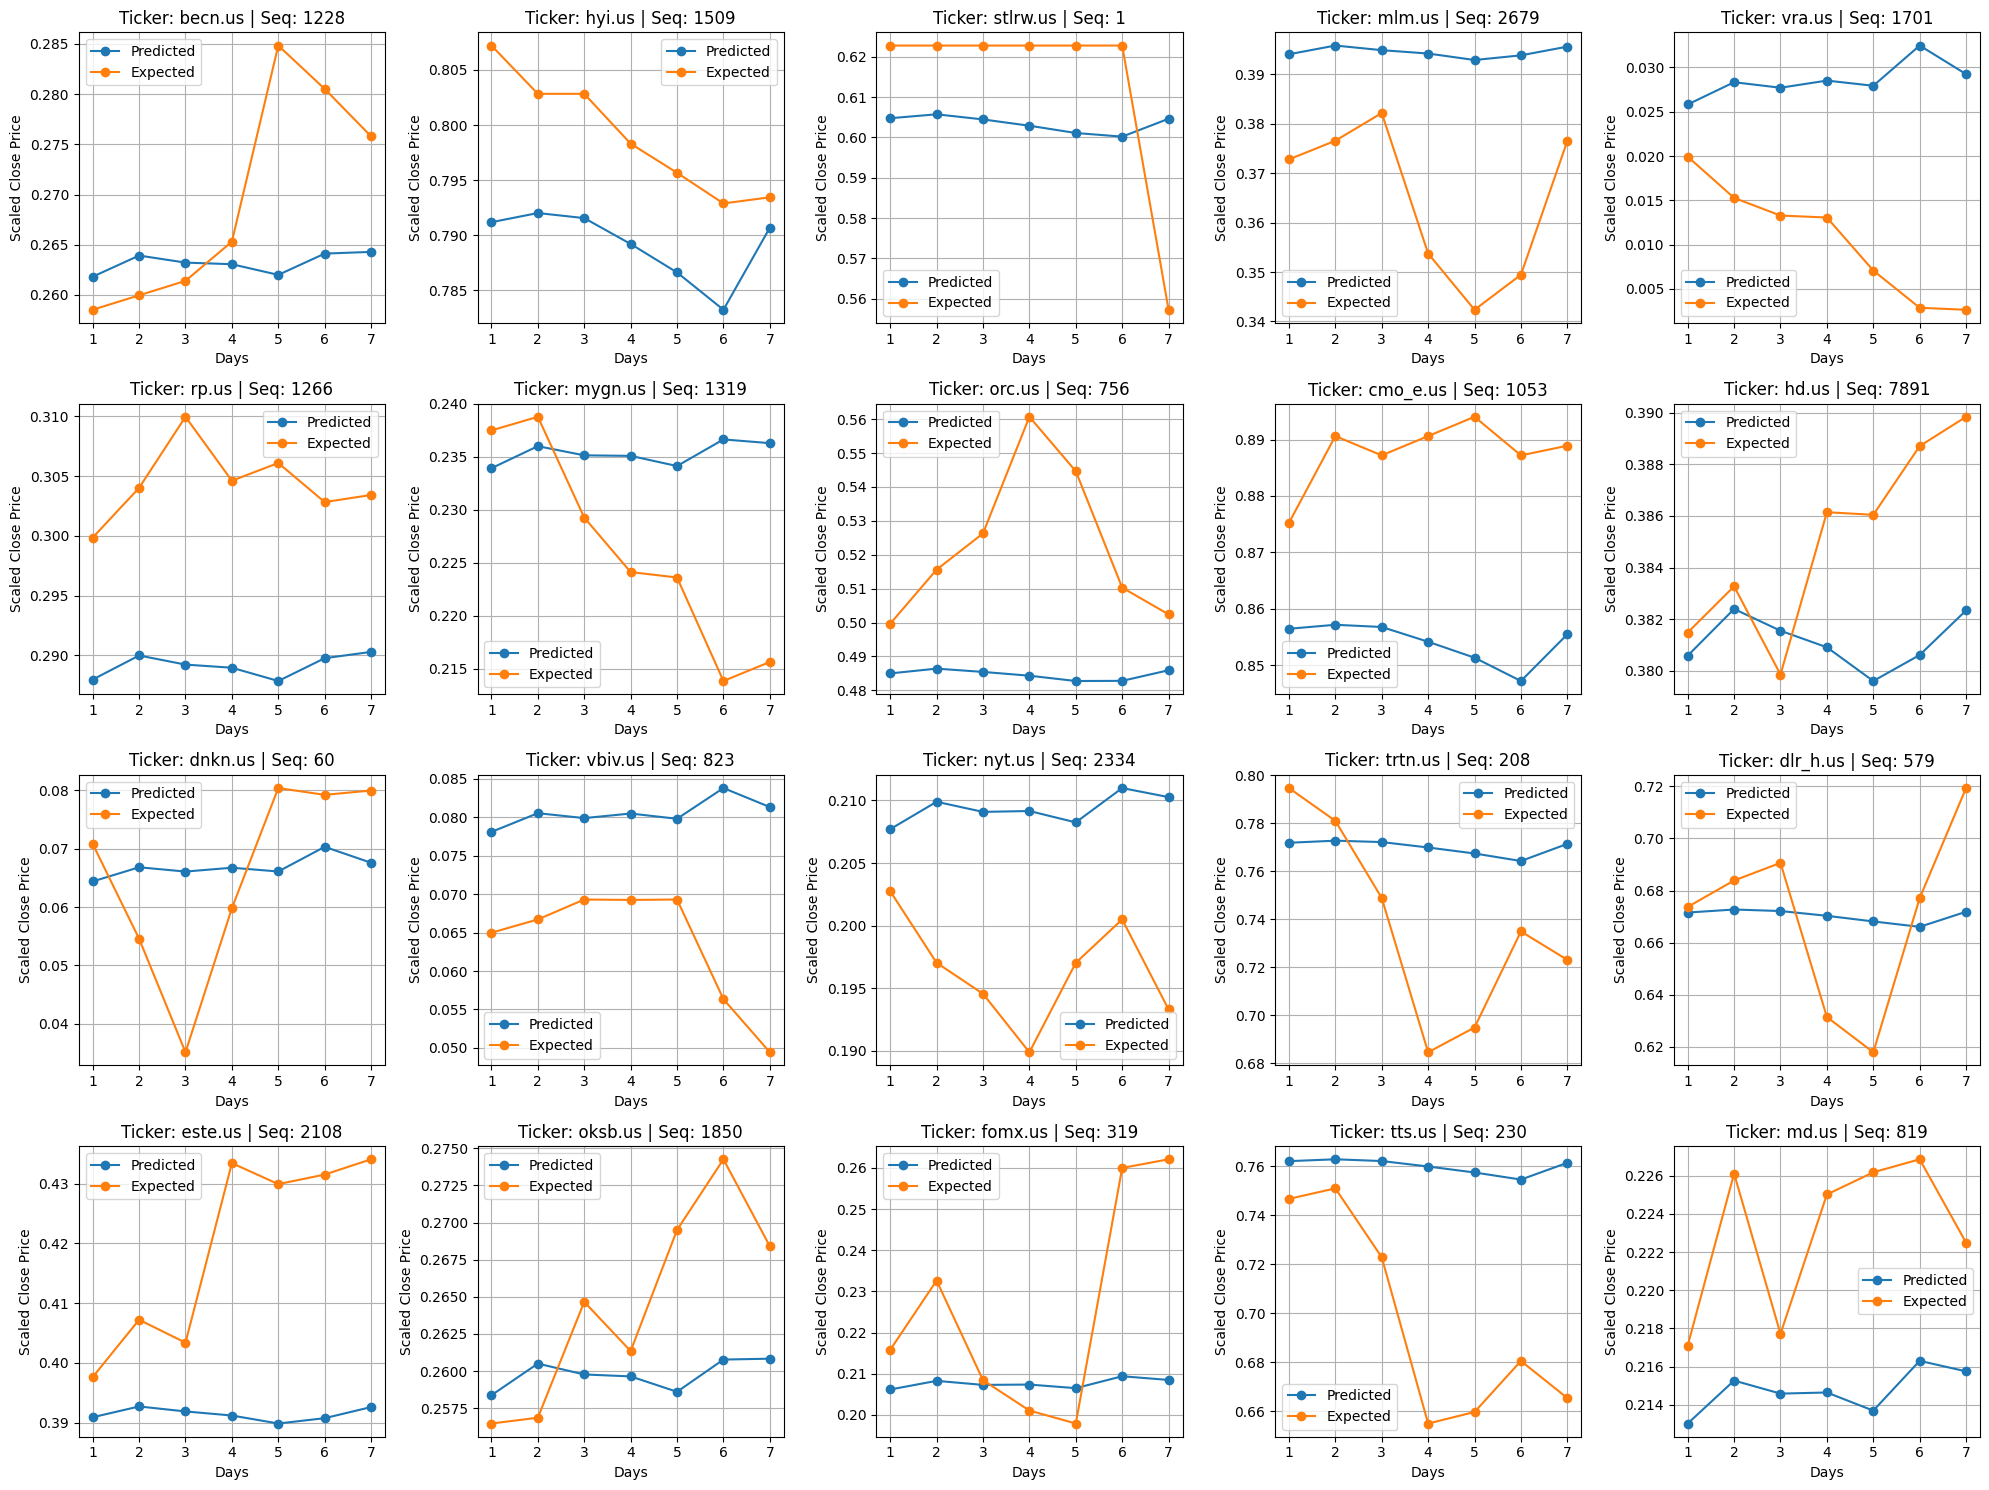

In [118]:
new_tickers = list(new_tickers)

rows, cols = 4, 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
axes = axes.flatten()

for i, ticker in enumerate(new_tickers):
    num_sequences = len(new_data[new_data['Ticker'] == ticker]) - sequence_length - predicted_days + 1

    start_idx = sum(
        len(new_data[new_data['Ticker'] == t]) - sequence_length - predicted_days + 1
        for t in new_tickers[:new_tickers.index(ticker)]
    )

    random_sequence = random.randint(0, num_sequences - 1)

    predicted_output = predictions[start_idx + random_sequence]
    expected_output = y[start_idx + random_sequence]

    ax = axes[i]
    days = np.arange(1, predicted_days + 1)
    ax.plot(days, predicted_output, label='Predicted', marker='o')
    ax.plot(days, expected_output, label='Expected', marker='o')

    ax.set_title(f'Ticker: {ticker} | Seq: {random_sequence + 1}')
    ax.set_xlabel('Days')
    ax.set_ylabel('Scaled Close Price')
    ax.legend()
    ax.grid(True)

for j in range(len(new_tickers), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()